In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import datetime
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import gc
import glob

from netCDF4 import Dataset

from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.patheffects as PathEffects
from global_land_mask import globe
import matplotlib.patches as mpatches

import math

In [2]:
path = '/glade/work/noteng/masters-research/data/'

observed_data = 'saved-files1/sum_all_lwe_precip_rate-simulated.nc'
simulated_data = 'saved-files/ensemble-mean1-LAM1km.nc'

observed = xr.open_dataarray(f"{path}{observed_data}")
simulated = xr.open_dataarray(f"{path}{simulated_data}")
# observed = xr.open_dataarray('../lwe_precip/saved-files/sum_all_lwe_precip_rate-simulated.nc')
# simulated = xr.open_dataarray('../LAM1-1km-precip-rate/saved-files/ensemble-mean1-LAM1km.nc')

## Getting the max and min values for observed and simulated coords

In [3]:
np.max(observed['lon']), np.min(observed['lon'])

(<xarray.DataArray 'lon' ()>
 array(37.355568, dtype=float32),
 <xarray.DataArray 'lon' ()>
 array(-8.336464, dtype=float32))

In [4]:
np.max(observed['lat']), np.min(observed['lat'])

(<xarray.DataArray 'lat' ()>
 array(73.21084, dtype=float32),
 <xarray.DataArray 'lat' ()>
 array(55.788555, dtype=float32))

In [5]:
np.max(simulated['XLONG']), np.min(simulated['XLONG'])

(<xarray.DataArray 'XLONG' ()>
 array(29.769287, dtype=float32),
 <xarray.DataArray 'XLONG' ()>
 array(-13.991577, dtype=float32))

In [6]:
np.max(simulated['XLAT']), np.min(simulated['XLAT'])

(<xarray.DataArray 'XLAT' ()>
 array(77.81944, dtype=float32),
 <xarray.DataArray 'XLAT' ()>
 array(67.602486, dtype=float32))

# mask precip values over ocean

In [7]:
observed_ocean = globe.is_ocean(observed['lat'], observed['lon'])
observed_ocean

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [8]:
simulated_ocean = globe.is_ocean(simulated['XLAT'], simulated['XLONG'])
simulated_ocean

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [9]:
observed = observed.where(observed_ocean, other=0)
observed

<xarray.DataArray 'lwe_precipitation_rate' (Yc: 1869, Xc: 1554)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * Xc       (Xc) float32 -2.95e+05 -2.94e+05 -2.93e+05 ... 1.257e+06 1.258e+06
  * Yc       (Yc) float32 8.124e+06 8.123e+06 8.122e+06 ... 6.257e+06 6.256e+06
    lon      (Yc, Xc) float32 -8.336 -8.31 -8.284 -8.257 ... 27.11 27.12 27.14
    lat      (Yc, Xc) float32 71.81 71.81 71.82 71.82 ... 55.85 55.85 55.85

In [10]:
simulated = simulated.where(simulated_ocean, other=0)
simulated

<xarray.DataArray (south_north: 1080, west_east: 1080)>
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 2.9434774e+00, 2.7582018e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 2.8324416e+00, 2.6607432e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.5118497e-03,
        1.5270191e-03, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.5745230e-03,
        1.5921580e-03, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)
Coordinates:
    XLAT     (south_north, west_east) float32 67.6 67.6 67.61 ... 76.94 76.94
    XLONG    (south_north, west_east) float32 -4.853 -4.83 ... 29.73 29.77
Dimensions without coordinates: south_north, west_east

### Since the observed domain extends to the far south and simulated domain does not, it is good to cut off the observed southern part before performing the calculations on it

In [11]:
# Define the longitude and latitude ranges
# lon_min, lon_max = -4.8526306, 29.769287
# lat_min, lat_max = 67.602486, 76.93586

lon_min, lon_max = np.min(simulated['XLONG']).data, np.max(simulated['XLONG']).data
lat_min, lat_max = np.min(simulated['XLAT']).data, np.max(simulated['XLAT']).data

# Mask the data based on longitude and latitude ranges
masked_data_observed = observed.where((observed['lon'] > lon_min) & (observed['lon'] < lon_max) &
                         (observed['lat'] > lat_min) & (observed['lat'] < lat_max), drop=True)
masked_data_observed

<xarray.DataArray 'lwe_precipitation_rate' (Yc: 626, Xc: 1418)>
array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * Xc       (Xc) float32 -2.95e+05 -2.94e+05 -2.93e+05 ... 1.121e+06 1.122e+06
  * Yc       (Yc) float32 8.124e+06 8.123e+06 8.122e+06 ... 7.5e+06 7.499e+06
    lon      (Yc, Xc) float32 -8.336 -8.31 -8.284 -8.257 ... 29.3 29.32 29.35
    lat      (Yc, Xc) float32 71.81 71.81 71.82 71.82 ... 66.96 66.96 66.96

In [12]:
np.nanpercentile(masked_data_observed.data, 90), np.nanmean(masked_data_observed.data)

(1.9655239582061768, 0.45946276)

In [13]:
masked_data_observed1 = masked_data_observed.copy()
masked_data_observed1 = masked_data_observed1.where((masked_data_observed1['lon'] >= 10) & (masked_data_observed1['lon'] <= 16.2) & (masked_data_observed1['lat'] >= 68) & (masked_data_observed1['lat'] <= 70), drop=True)
np.max(masked_data_observed1)

<xarray.DataArray 'lwe_precipitation_rate' ()>
array(9.529623, dtype=float32)

In [14]:
simulated1 = simulated.copy()
simulated1 = simulated1.where((simulated1['XLONG'] >= 10) & (simulated1['XLONG'] <= 16.2) & (simulated1['XLAT'] >= 68) & (simulated1['XLAT'] <= 70), drop=True)
np.max(simulated1)

<xarray.DataArray ()>
array(16.16061, dtype=float32)

## Plot observed vrs simulated

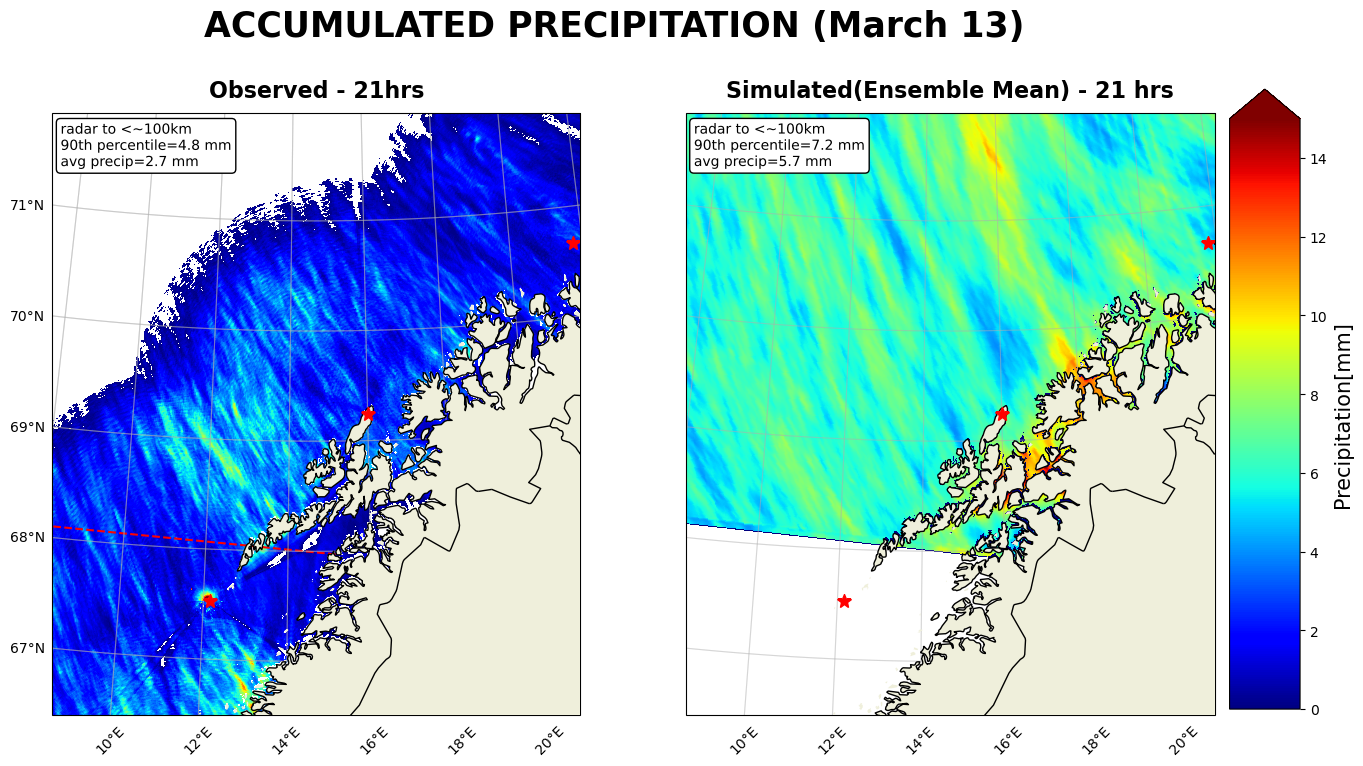

In [15]:
latA = 69.141281  # latitude of COMBLE site
lonA = 15.684166-1  # longitude of COMBLE site -1
xm, ym = 6, 2.75  # extent from center point in lon and lat

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), subplot_kw={
                           'projection': ccrs.Orthographic(lonA, latA)})

ax = ax.flatten()

names = ['Observed - 21hrs', 'Simulated(Ensemble Mean) - 21 hrs']

for i, v in enumerate(ax):
    # set extent
    extent = [lonA-xm, lonA+xm, latA-ym, latA+ym]
    ax[i].set_extent(extent)  # set extent of map
    ax[i].set_title(names[i], fontweight='bold', fontsize=16, pad=11)


    # plotting coastlines at a very high resolution: 10m
    ax[i].coastlines(resolution='10m', zorder=7)
    # add borders
    ax[i].add_feature(cfeature.BORDERS, zorder=7)
    # add land
    ax[i].add_feature(cfeature.LAND, linewidth=1.5, alpha=1, zorder=6)
    # add grid lines
    gl = ax[i].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=False; gl.left_labels=False
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'rotation': 45}; gl.ylabel_style = {'color': 'black'} 
    # add terrain
    # ax.add_feature(cfeature.GSHHSFeature(scale='high'))
    # Radar locations
    ax[i].plot(16.00297, 69.24139, color='red', marker='*', markersize=10.5,
            transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location of Radar Andoya
    ax[i].plot(12.1544, 67.5264, color='red', marker='*', markersize=10.5,
            transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at SW
    ax[i].plot(21.7544, 70.664, color='red', marker='*', markersize=10.5,
            transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at NE
    

    


# Create the 'jet' colormap
cmap = plt.get_cmap('jet')
# # Modify the colormap
colors = cmap(np.arange(cmap.N))
colors[0] = np.array([1.0, 1.0, 1.0, 1.0])  # change the first color to white
new_cmap = mcolors.LinearSegmentedColormap.from_list("new_jet", colors)

norm = Normalize(vmin=0, vmax=15)
# Create the box around the text
bbox = dict(facecolor='white', edgecolor='black', boxstyle='round')
path_effects = [PathEffects.withStroke(linewidth=1.5, foreground='w')]
    
cs = ax[0].pcolormesh(observed['lon'], 
                   observed['lat'], 
                   observed,
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap,
                   norm=norm)


gl = ax[0].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=False; gl.left_labels=True
gl = ax[0].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=True; gl.left_labels=False
gl.xlabel_style = {'rotation': 45}

latA1=71.51; lonA1=7.3
# ax[0].text(lonA1, latA1, f'90th percentile={np.percentile(observed.data, 90):.1f} mm\navg precip={np.mean(observed.data):.1f} mm', 
#         transform=ccrs.PlateCarree(), color='black', fontsize=10,  bbox=bbox, path_effects=path_effects)
ax[0].text(lonA1+0.1, latA1-0.15, f'radar to <~100km\n90th percentile={np.nanpercentile(masked_data_observed1.data, 90):.1f} mm\navg precip={np.nanmean(masked_data_observed1.data):.1f} mm', 
        transform=ccrs.PlateCarree(), color='black', fontsize=10,  bbox=bbox, path_effects=path_effects)

ax[0].plot([8, 15.2], [68.1, 67.97],  transform=ccrs.PlateCarree(), color='red', linestyle='--')

    
cs = ax[1].pcolormesh(simulated['XLONG'], 
                   simulated['XLAT'], 
                   simulated,
                   transform=ccrs.PlateCarree(),
                   cmap='jet',
                   norm=norm
                      )

gl = ax[1].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=True; gl.left_labels=False
gl.xlabel_style = {'rotation': 45}

# latA1=71.53; lonA1=7.3
ax[1].text(lonA1+0.08, latA1-0.15, f'radar to <~100km\n90th percentile={np.nanpercentile(simulated1.data, 90):.1f} mm\navg precip={np.nanmean(simulated1.data):.1f} mm', 
        transform=ccrs.PlateCarree(), color='black', fontsize=10,  bbox=bbox, path_effects=path_effects)


# # # # Add a colorbar axis at the right of the graph
cbar_ax = fig.add_axes([0.91, 0.2, 0.047, 0.62])  # lbwh

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', extend='max')
cbar.set_label("Precipitation[mm]", fontsize=15)

fig.suptitle('ACCUMULATED PRECIPITATION (March 13)', y=0.90, fontweight='bold', fontsize=25);

# fig.savefig('observed-vrs-simulated.png', bbox_inches='tight',dpi=500);

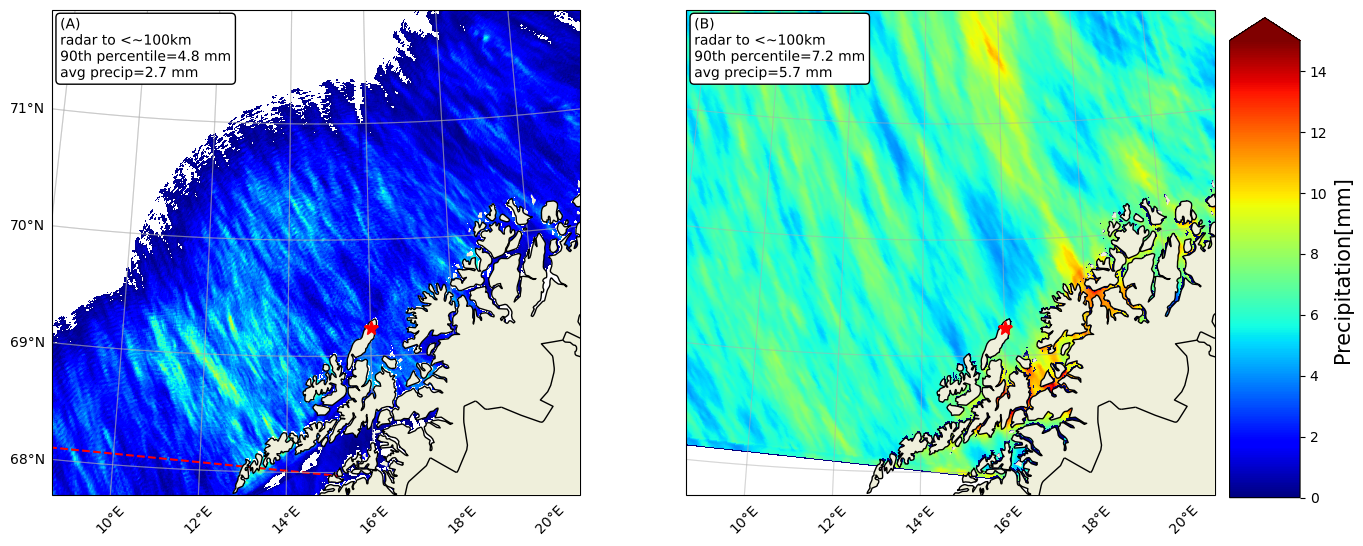

In [16]:
latA = 69.141281  # latitude of COMBLE site
lonA = 15.684166-1  # longitude of COMBLE site -1
xm, ym = 6, 2.75  # extent from center point in lon and lat

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), subplot_kw={
                           'projection': ccrs.Orthographic(lonA, latA)})

ax = ax.flatten()

# names = ['Observed - 21hrs', 'Simulated(Ensemble Mean) - 21 hrs']

for i, v in enumerate(ax):
    # set extent
    extent = [lonA-xm, lonA+xm, latA-ym+1.3, latA+ym]
    ax[i].set_extent(extent)  # set extent of map
    # ax[i].set_title(names[i], fontweight='bold', fontsize=16, pad=11)

    # plotting coastlines at a very high resolution: 10m
    ax[i].coastlines(resolution='10m', zorder=7)
    # add borders
    ax[i].add_feature(cfeature.BORDERS, zorder=7)
    # add land
    ax[i].add_feature(cfeature.LAND, linewidth=1.5, alpha=1, zorder=6)
    # add grid lines
    gl = ax[i].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=False; gl.left_labels=False
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'rotation': 45}; gl.ylabel_style = {'color': 'black'} 
    # add terrain
    # ax.add_feature(cfeature.GSHHSFeature(scale='high'))
    # Radar locations
    ax[i].plot(16.00297, 69.24139, color='red', marker='*', markersize=10.5,
            transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location of Radar Andoya
    ax[i].plot(12.1544, 67.5264, color='red', marker='*', markersize=10.5,
            transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at SW
    ax[i].plot(21.7544, 70.664, color='red', marker='*', markersize=10.5,
            transform=ccrs.PlateCarree(), zorder=8)  # plot red star at location at NE
    

    


# Create the 'jet' colormap
cmap = plt.get_cmap('jet')
# # Modify the colormap
colors = cmap(np.arange(cmap.N))
colors[0] = np.array([1.0, 1.0, 1.0, 1.0])  # change the first color to white
new_cmap = mcolors.LinearSegmentedColormap.from_list("new_jet", colors)

norm = Normalize(vmin=0, vmax=15)
# Create the box around the text
bbox = dict(facecolor='white', edgecolor='black', boxstyle='round')
path_effects = [PathEffects.withStroke(linewidth=1.5, foreground='w')]
    
cs = ax[0].pcolormesh(observed['lon'], 
                   observed['lat'], 
                   observed,
                   transform=ccrs.PlateCarree(),
                   cmap=new_cmap,
                   norm=norm)


gl = ax[0].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=False; gl.left_labels=True
gl = ax[0].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=True; gl.left_labels=False
gl.xlabel_style = {'rotation': 45}

latA1=71.51; lonA1=7.3
# ax[0].text(lonA1, latA1, f'90th percentile={np.percentile(observed.data, 90):.1f} mm\navg precip={np.mean(observed.data):.1f} mm', 
#         transform=ccrs.PlateCarree(), color='black', fontsize=10,  bbox=bbox, path_effects=path_effects)
# ax[0].text(lonA1+0.1, latA1, f'90th percentile={np.nanpercentile(masked_data_observed.data, 90):.1f} mm\navg precip={np.nanmean(masked_data_observed.data):.1f} mm', 
#         transform=ccrs.PlateCarree(), color='black', fontsize=10,  bbox=bbox, path_effects=path_effects)


ax[0].text(lonA1+0.50, latA1-0.23, f'(A)\nradar to <~100km\n90th percentile={np.nanpercentile(masked_data_observed1.data, 90):.1f} mm\navg precip={np.nanmean(masked_data_observed1.data):.1f} mm', 
        transform=ccrs.PlateCarree(), color='black', fontsize=10,  bbox=bbox, path_effects=path_effects)

# Drawing line to achieve the same domain as simulated
ax[0].plot([8, 15.2], [68.1, 67.97],  transform=ccrs.PlateCarree(), color='red', linestyle='--')

    
cs = ax[1].pcolormesh(simulated['XLONG'], 
                   simulated['XLAT'], 
                   simulated,
                   transform=ccrs.PlateCarree(),
                   cmap='jet',
                   norm=norm
                      )

gl = ax[1].gridlines(x_inline=False, alpha=0.3); gl.bottom_labels=True; gl.left_labels=False
gl.xlabel_style = {'rotation': 45}

# latA1=71.53; lonA1=7.3
# ax[1].text(lonA1+0.05, latA1, f'90th percentile={np.percentile(simulated.data, 90):.1f} mm\navg precip={np.mean(simulated.data):.1f} mm', 
#         transform=ccrs.PlateCarree(), color='black', fontsize=10,  bbox=bbox, path_effects=path_effects)


ax[1].text(lonA1+0.50, latA1-0.23, f'(B)\nradar to <~100km\n90th percentile={np.nanpercentile(simulated1.data, 90):.1f} mm\navg precip={np.nanmean(simulated1.data):.1f} mm', 
        transform=ccrs.PlateCarree(), color='black', fontsize=10,  bbox=bbox, path_effects=path_effects)



# # # # Add a colorbar axis at the right of the graph
# cbar_ax = fig.add_axes([0.91, 0.2, 0.047, 0.62])  # lbwh
cbar_ax = fig.add_axes([0.91, 0.25, 0.047, 0.48])  # lbwh

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', extend='max')
cbar.set_label("Precipitation[mm]", fontsize=15)

# fig.suptitle('ACCUMULATED PRECIPITATION (March 13)', y=0.90, fontweight='bold', fontsize=25);

# fig.savefig('observed-vrs-simulated-pub.png', bbox_inches='tight',dpi=500);

### _Calculating for biases_

In [17]:
# Bias = M_avg - R_avg
M_avg, R_avg = np.nanmean(simulated1.data), np.nanmean(masked_data_observed1.data)
M_avg, R_avg

(5.6511364, 2.6873014)

In [18]:
bias = M_avg - R_avg
bias

2.963835

In [19]:
print(f"Since the bias is positive, it indicates that the model overestimates the precipitation by {bias:.2f} mm")

Since the bias is positive, it indicates that the model overestimates the precipitation by 2.96 mm
